# Benchmark: PXD014777 HeLa, Yeast and Ecoli dataset

This notebook contains code to benchmark the PIPP model on [PXD014777 dataset](https://proteomecentral.proteomexchange.org/cgi/GetDataset?ID=PXD014777) - Tenzer.nomatching_MaxQuant.txt.zip and HeLa10replicates2h-1.0.10.4_MaxQuant.txt.zip. We'll use the following txt files from the datasets:

HeLa10replicates2h-1.0.10.4_MaxQuant.txt.zip:
- allPeptides.txt: All the peptides with MS-1 data for HeLa
- evidence.txt: A subset of the peptides in allPeptides.txt, which contains both MS-1 and MS-2 data


Tenzer.nomatching_MaxQuant.txt.zip:
- evidence.txt: Contains both MS-1 and MS-2 data for the 3 species: Ecoli, Yeast and HeLa

We'll use PIPP to compute the embeddings of each MS-1 datapoint. Followed by peptide identity propagation using the MS1/MS2 data as the support data. Since multiple HeLa are available in the MS2 dataset, and only HeLU in the MS1 dataset, we'll also compute false transfer rates.

Let's start with the imports.

In [1]:
%%capture

%matplotlib inline

%load_ext autoreload
%autoreload 2

from collections import defaultdict
import re
import os

import pipp
import pipp.utils

import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn.functional as F

from pynndescent import NNDescent

np.random.seed(0)

Let's define the paths to the data and the pretrained model.

In [2]:
HELA_PEPTIDES_PATH = "../../data/HeLa10replicates/txt/allPeptides.txt"
HELA_EVIDENCE_PATH = "../../data/HeLa10replicates/txt/evidence.txt"
HELA_EVIDENCE_MAPPED_PATH = "../../data/HeLa10replicates/txt/evidence_mapped.txt" # @NOTE: gets auto-generated if file doesn't exist

SPECIES_EVIDENCE_PATH = "../../data/tenzer_nomatching/txt/evidence.txt"

PRETRAINED_MODEL_PATH = "../../data/PXD019086_PXD010012_combined_evidence_90Kto20Ksplit_5query_1shot_fullmodel_featuresScaled_allPeptidesTxtFeatures_modSeqSpecies_hidden64_latent10_maxEpoch300_164trainways_xlatent_conditionalEmbedding.pth"

## Data Preparation

Let's load and clean the data.

In [3]:
HeLa_MS1_raw_data = pd.read_csv(HELA_PEPTIDES_PATH, sep='\t', header=0)
HeLa_MS1_raw_data['Dataset'] = 'HeLa'

In [4]:
if not os.path.isfile(HELA_EVIDENCE_MAPPED_PATH):
    HeLa_MS2_raw_data = pd.read_csv(HELA_EVIDENCE_PATH, sep='\t', header=0, low_memory=False)
    HeLa_MS2_raw_data = pipp.utils.link_MSMS_to_MS(HeLa_MS2_raw_data, HeLa_MS1_raw_data, verbose=True)
    HeLa_MS2_raw_data.to_csv(HELA_EVIDENCE_MAPPED_PATH, sep='\t', index=True)

In [5]:
HeLa_MS2_raw_data = pd.read_csv(HELA_EVIDENCE_MAPPED_PATH, sep='\t', header=0, low_memory=False)
HeLa_MS2_raw_data['Dataset'] = 'HeLa'

In [6]:
species_MS2_raw_data = pd.read_csv(SPECIES_EVIDENCE_PATH, sep='\t', header=0, low_memory=False)
species_MS2_raw_data['Dataset'] = 'Multi-species'

Let's look at the dimensions of the data.

In [7]:
print('HeLa MS1 data shape:        {}'.format(HeLa_MS1_raw_data.shape))
print('HeLa MS1+MS2 data shape:    {}'.format(HeLa_MS2_raw_data.shape))
print('species MS1+MS2 data shape: {}'.format(species_MS2_raw_data.shape))

HeLa MS1 data shape:        (4101555, 25)
HeLa MS1+MS2 data shape:    (634466, 72)
species MS1+MS2 data shape: (219367, 71)


### MS1 data preprocessing

Let's look at the features available in the MS1 data:

In [8]:
HeLa_MS1_raw_data.columns.unique()

Index(['Raw file', 'Charge', 'm/z', 'Mass', 'Resolution',
       'Number of data points', 'Number of frames', 'Number of isotopic peaks',
       'Isotope correlation', 'Mass fractional part', 'Mass deficit',
       'Retention time', 'Retention length', 'Retention length (FWHM)',
       'Min frame index', 'Max frame index', 'Ion mobility index',
       'Ion mobility index length', 'Ion mobility index length (FWHM)',
       'Intensity', 'Intensities', 'Number of pasef MS/MS', 'Pasef MS/MS IDs',
       'MS/MS scan number', 'Dataset'],
      dtype='object')

Let's filter out low quality peptides.

In [9]:
# filter out low quality peptides
HeLa_MS1_data = HeLa_MS1_raw_data.loc[(HeLa_MS1_raw_data['Charge'] != 1) & (HeLa_MS1_raw_data['Intensity'] > 0)]

In [10]:
HeLa_MS1_raw_peptides_per_run = [np.sum(HeLa_MS1_raw_data['Raw file'] == run) for run in HeLa_MS1_raw_data['Raw file'].unique()]
HeLa_MS1_peptides_per_run = [np.sum(HeLa_MS1_data['Raw file'] == run) for run in HeLa_MS1_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

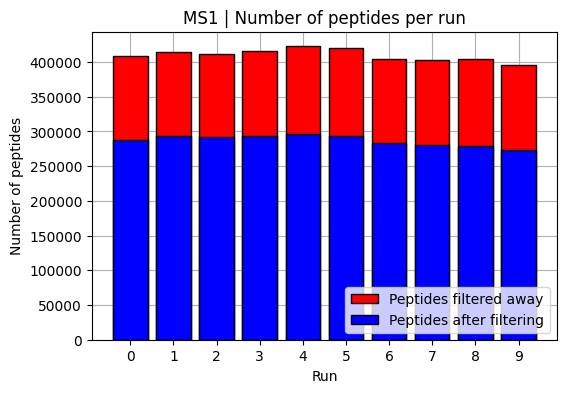

In [11]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(HeLa_MS1_raw_peptides_per_run)), HeLa_MS1_raw_peptides_per_run, color='red', edgecolor='black')
ax.bar(range(len(HeLa_MS1_peptides_per_run)), HeLa_MS1_peptides_per_run, color='blue', edgecolor='black')
ax.legend(['Peptides filtered away', 'Peptides after filtering'], loc='lower right')

ax.grid(True)
ax.set_axisbelow(True)
ax.set_xticks(np.arange(0, len(HeLa_MS1_raw_peptides_per_run), 1))
ax.set_title("MS1 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [12]:
print(f"After filtering | MS1 data points: {HeLa_MS1_data.shape[0]} ({HeLa_MS1_data.shape[0] / HeLa_MS1_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS1 data points: 2871496 (70.01%)


### MS2 (MSMS) data preprocessing

#### HeLa - MS2 data

Let's look at the features available in the MS2 data:

In [13]:
HeLa_MS2_raw_data.columns.unique()

Index(['Unnamed: 0', 'Sequence', 'Length', 'Modifications',
       'Modified sequence', 'Oxidation (M) Probabilities',
       'Oxidation (M) Score Diffs', 'Acetyl (Protein N-term)', 'Oxidation (M)',
       'Missed cleavages', 'Proteins', 'Leading proteins',
       'Leading razor protein', 'Gene names', 'Protein names', 'Type',
       'Raw file', 'Experiment', 'MS/MS m/z', 'Charge', 'm/z', 'Mass',
       'Resolution', 'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z differe

Let's filter out low quality peptides.

In [14]:
# filter out low quality peptides
HeLa_MS2_data = HeLa_MS2_raw_data.loc[(HeLa_MS2_raw_data['Charge'] != 1) & (HeLa_MS2_raw_data['Intensity'] > 0)]

# keep the most intense peptides
HeLa_MS2_data = HeLa_MS2_data.loc[HeLa_MS2_data.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

# remove contaminants
HeLa_MS2_data = HeLa_MS2_data.loc[[(not bool(re.search('CON__|REV__', i))) for i in HeLa_MS2_data['Leading razor protein'].tolist()]]

# define identifier for each peptide
HeLa_MS2_data['PrecursorID'] = HeLa_MS2_data['Modified sequence'].astype(str).str.cat(HeLa_MS2_data['Charge'].astype(str), sep='')

In [15]:
HeLa_MS2_raw_peptides_per_run = [np.sum(HeLa_MS2_raw_data['Raw file'] == run) for run in HeLa_MS2_raw_data['Raw file'].unique()]
HeLa_MS2_peptides_per_run = [np.sum(HeLa_MS2_data['Raw file'] == run) for run in HeLa_MS2_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

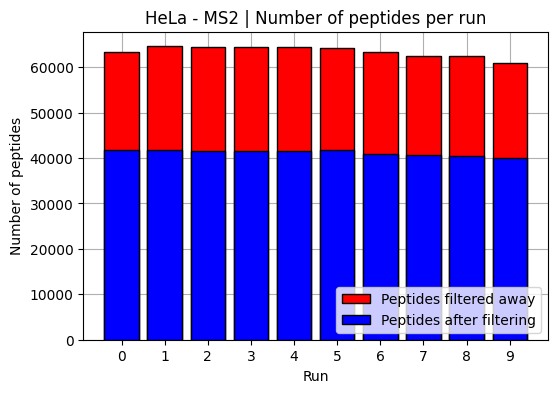

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(HeLa_MS2_raw_peptides_per_run)), HeLa_MS2_raw_peptides_per_run, color='red', edgecolor='black')
ax.bar(range(len(HeLa_MS2_peptides_per_run)), HeLa_MS2_peptides_per_run, color='blue', edgecolor='black')
ax.legend(['Peptides filtered away', 'Peptides after filtering'], loc='lower right')

ax.grid(True)
ax.set_axisbelow(True)
ax.set_title("HeLa - MS2 | Number of peptides per run")
ax.set_xticks(np.arange(0, len(HeLa_MS2_raw_peptides_per_run), 1))
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [17]:
print(f"After filtering | MS2 data points: {HeLa_MS2_data.shape[0]} ({HeLa_MS2_data.shape[0] / HeLa_MS2_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS2 data points: 411838 (64.91%)


Let's see how many runs a peptide is present in.

In [18]:
peptides_abundances = HeLa_MS2_data['PrecursorID'].value_counts()

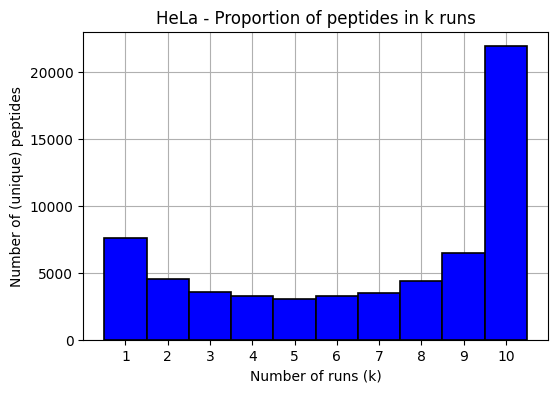

In [19]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(peptides_abundances, bins=range(1, np.max(peptides_abundances)+2), color='blue', edgecolor='black', linewidth=1.2, align='left')
ax.set_xticks(range(1, np.max(peptides_abundances)+1))
ax.set_title('HeLa - Proportion of peptides in k runs')
ax.set_xlabel('Number of runs (k)')
ax.set_ylabel('Number of (unique) peptides')
ax.grid(True)
ax.set_axisbelow(True)

Let's add a column with species.

In [20]:
HeLa_MS2_data['Species'] = 'HeLa'

#### Ecoli, Yeast and HeLa - MS2 data

Let's look at the features available in the MS2 data:

In [21]:
species_MS2_raw_data.columns.unique()

Index(['Sequence', 'Length', 'Modifications', 'Modified sequence',
       'Oxidation (M) Probabilities', 'Oxidation (M) Score Diffs',
       'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
       'Proteins', 'Leading proteins', 'Leading razor protein', 'Gene names',
       'Protein names', 'Type', 'Raw file', 'Experiment', 'MS/MS m/z',
       'Charge', 'm/z', 'Mass', 'Resolution',
       'Uncalibrated - Calibrated m/z [ppm]',
       'Uncalibrated - Calibrated m/z [Da]', 'Mass error [ppm]',
       'Mass error [Da]', 'Uncalibrated mass error [ppm]',
       'Uncalibrated mass error [Da]', 'Max intensity m/z 0', 'Retention time',
       'Retention length', 'Calibrated retention time',
       'Calibrated retention time start', 'Calibrated retention time finish',
       'Retention time calibration', 'Ion mobility index',
       'Ion mobility length', '1/K0', '1/K0 length', 'Calibrated 1/K0', 'CCS',
       'CCS length', 'Match time difference', 'Match m/z difference',
       '

Let's filter out low quality peptides.

In [22]:
# filter out low quality peptides
species_MS2_data = species_MS2_raw_data.loc[(species_MS2_raw_data['Charge'] != 1) & (species_MS2_raw_data['Intensity'] > 0)]

# keep the most intense peptides
species_MS2_data = species_MS2_data.loc[species_MS2_data.groupby(['Modified sequence', 'Charge', 'Raw file'])['Intensity'].idxmax()]

# remove contaminants
species_MS2_data = species_MS2_data.loc[[(not bool(re.search('CON__|REV__', i))) for i in species_MS2_data['Leading razor protein'].tolist()]]

# define identifier for each peptide
species_MS2_data['PrecursorID'] = species_MS2_data['Modified sequence'].astype(str).str.cat(species_MS2_data['Charge'].astype(str), sep='')

In [23]:
species_MS2_raw_peptides_per_run = [np.sum(species_MS2_raw_data['Raw file'] == run) for run in species_MS2_raw_data['Raw file'].unique()]
species_MS2_peptides_per_run = [np.sum(species_MS2_data['Raw file'] == run) for run in species_MS2_data['Raw file'].unique()]

Text(0, 0.5, 'Number of peptides')

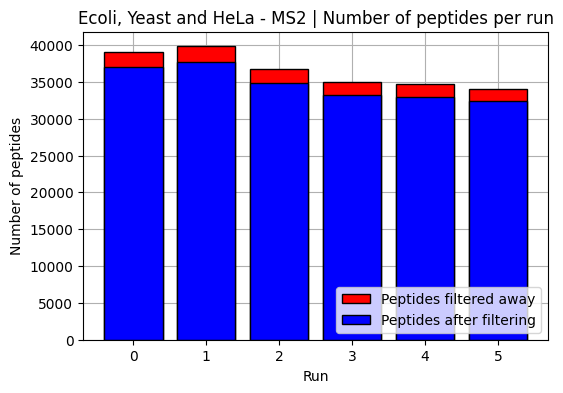

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(range(len(species_MS2_raw_peptides_per_run)), species_MS2_raw_peptides_per_run, color='red', edgecolor='black')
ax.bar(range(len(species_MS2_peptides_per_run)), species_MS2_peptides_per_run, color='blue', edgecolor='black')
ax.legend(['Peptides filtered away', 'Peptides after filtering'], loc='lower right')

ax.grid(True)
ax.set_axisbelow(True)
ax.set_title("Ecoli, Yeast and HeLa - MS2 | Number of peptides per run")
ax.set_xlabel("Run")
ax.set_ylabel("Number of peptides")

In [25]:
print(f"After filtering | MS2 data points: {species_MS2_data.shape[0]} ({species_MS2_data.shape[0] / species_MS2_raw_data.shape[0] * 100:.2f}%)")

After filtering | MS2 data points: 208091 (94.86%)


Let's see how many runs a peptide is present in.

In [26]:
peptides_abundances = species_MS2_data['PrecursorID'].value_counts()

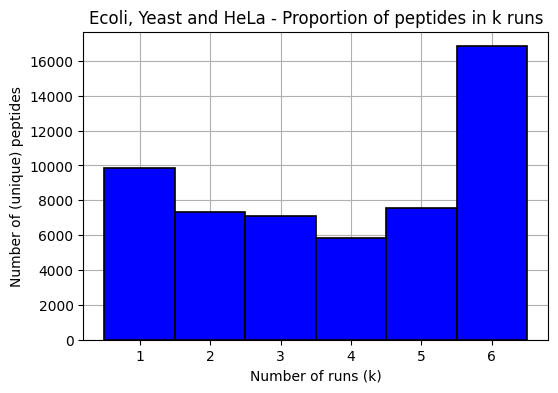

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(peptides_abundances, bins=range(1, np.max(peptides_abundances)+2), color='blue', edgecolor='black', linewidth=1.2, align='left')
ax.set_xticks(range(1, np.max(peptides_abundances)+1))
ax.set_title('Ecoli, Yeast and HeLa - Proportion of peptides in k runs')
ax.set_xlabel('Number of runs (k)')
ax.set_ylabel('Number of (unique) peptides')
ax.grid(True)
ax.set_axisbelow(True)

Let's add a column with species.

In [28]:
yeast_filter = species_MS2_data['Leading razor protein'].str.contains('YEAST')
ecoli_filter = species_MS2_data['Leading razor protein'].str.contains('ECOLI')
hela_filter = ~(yeast_filter | ecoli_filter)

species_MS2_data['Species'] = 'Unknown'
species_MS2_data.loc[yeast_filter, 'Species'] = 'Yeast'
species_MS2_data.loc[ecoli_filter, 'Species'] = 'Ecoli'
species_MS2_data.loc[hela_filter, 'Species'] = 'HeLa'

Let's look at the proportion of peptides in each species for the MS2 dataset with multiple species.

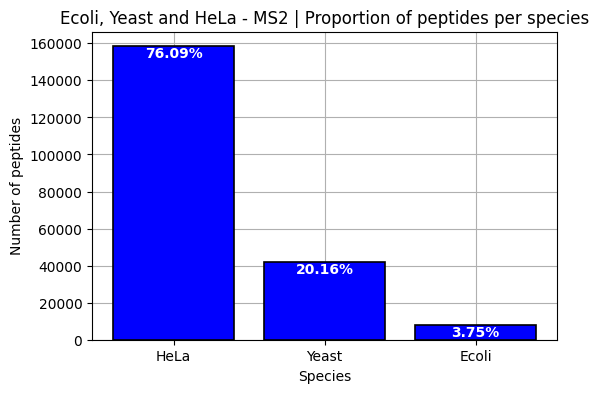

In [29]:
species = species_MS2_data['Species']

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(species.value_counts().index, species.value_counts(), color='blue', edgecolor='black', linewidth=1.2)
ax.set_title('Ecoli, Yeast and HeLa - MS2 | Proportion of peptides per species')
ax.set_xlabel('Species')
ax.set_ylabel('Number of peptides')
ax.grid(True)
ax.set_axisbelow(True)

for i, v in enumerate(species.value_counts()):
    y = v - 4000
    text = f"{v / species_MS2_data.shape[0] * 100:.2f}%"
    ax.text(i, y, text, ha='center', va='center', fontweight='bold', color='white')

### Feature Extraction

Let's extract the features which the model takes as input.

It seems like the two types of datasets (MS1 and MS2) use a different name for 'Ion mobilility index length' / 'Ion mobility length'. Let's rename one of them to be consistent between the datasets.

In [30]:
HeLa_MS1_data = HeLa_MS1_data.copy()
HeLa_MS1_data.rename(columns={'Ion mobility index length': 'Ion mobility length'}, inplace=True)

In [31]:
features = ['Charge', 'Mass', 'm/z', 'Retention time','Retention length', 'Ion mobility index', 'Ion mobility length','Number of isotopic peaks']

Let's look at the distribution of the features.

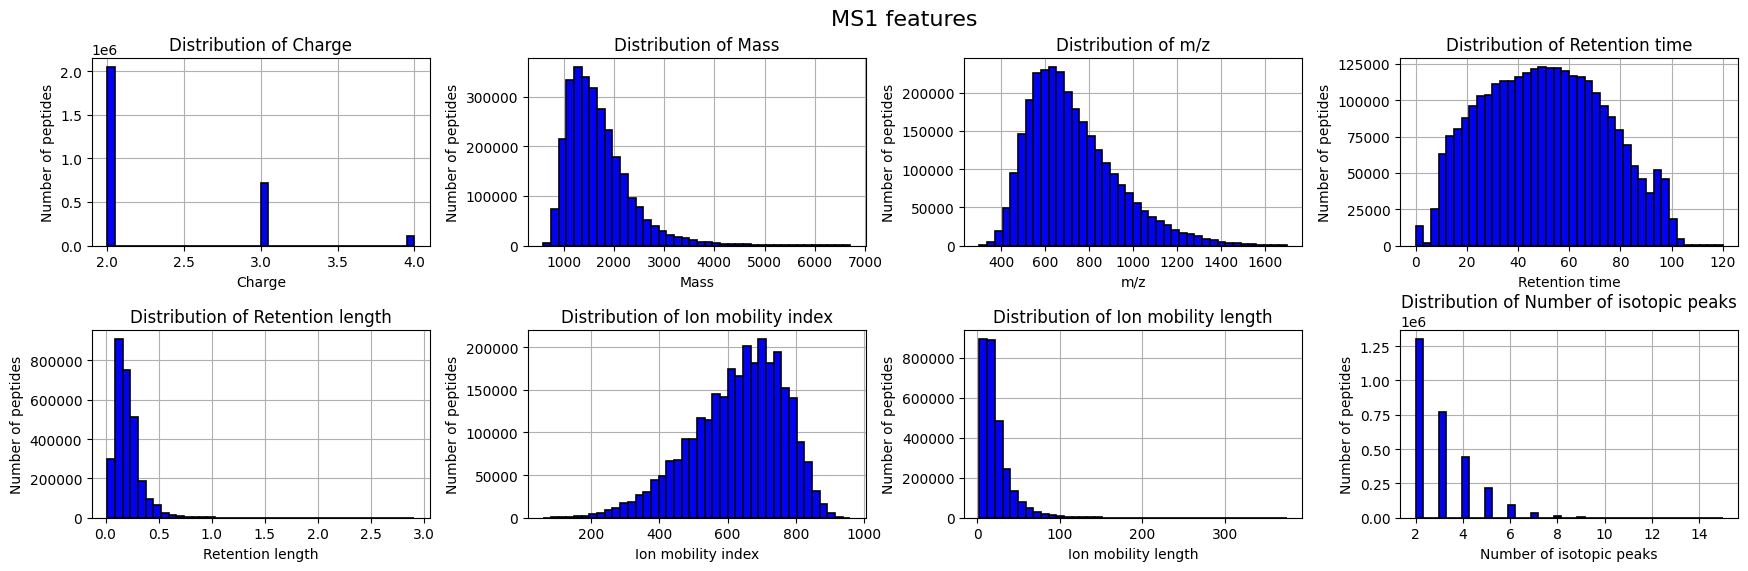

In [32]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('MS1 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(HeLa_MS1_data[feature], bins=40, color='blue', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

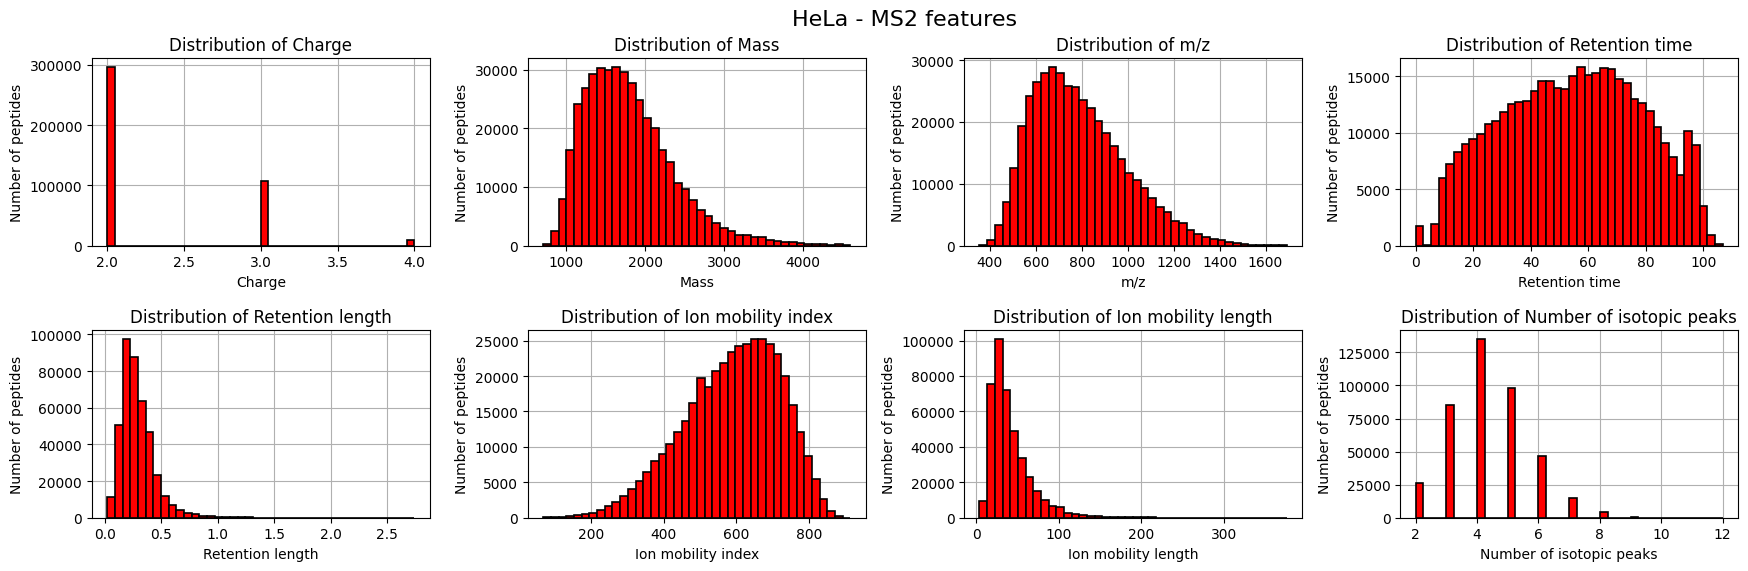

In [33]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('HeLa - MS2 features', fontsize=16)

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    ax.hist(HeLa_MS2_data[feature], bins=40, color='red', edgecolor='black', linewidth=1.2)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

Let's plot features by species as well for the species MS2 dataset.

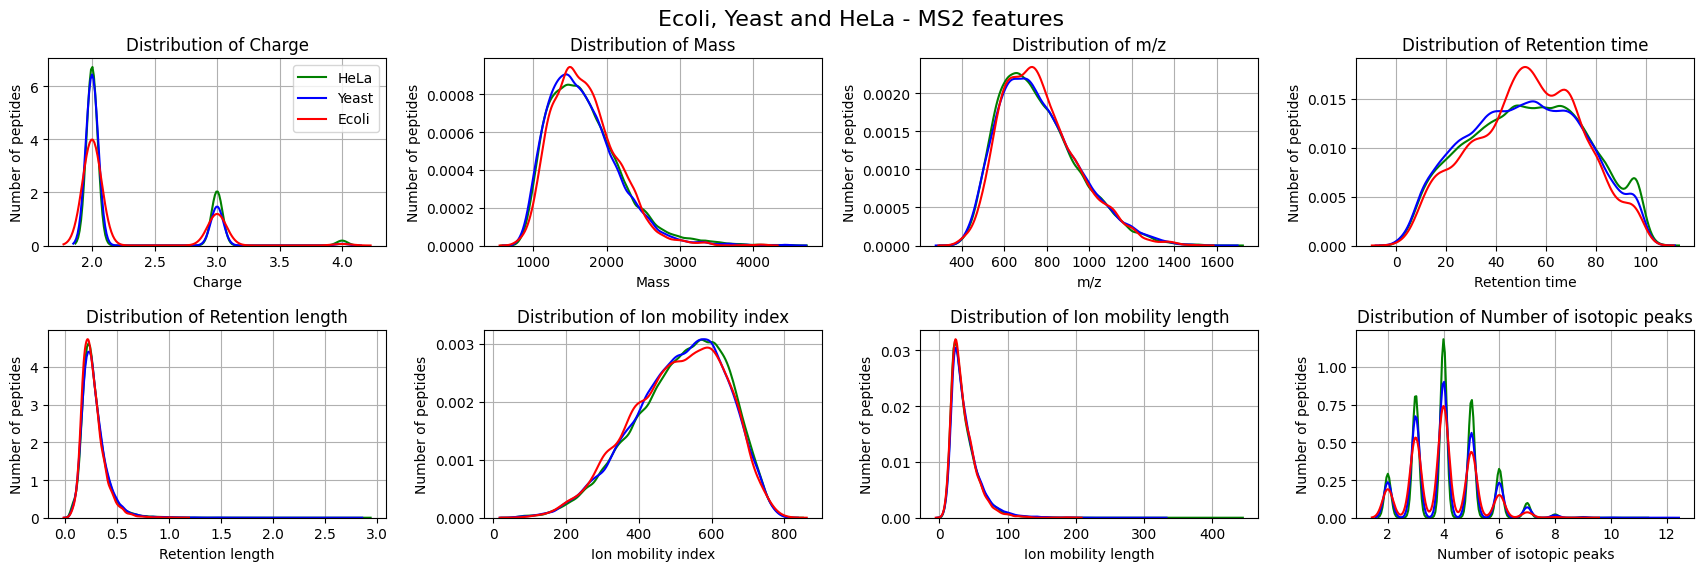

In [34]:
fig, axs = plt.subplots(figsize=(18, 6), ncols=4, nrows=2)
fig.tight_layout(pad=4.0)
fig.suptitle('Ecoli, Yeast and HeLa - MS2 features', fontsize=16)

yeast_filter = species_MS2_data['Species'] == 'Yeast'
ecoli_filter = species_MS2_data['Species'] == 'Ecoli'
hela_filter = species_MS2_data['Species'] == 'HeLa'

for i, feature in enumerate(features):
    ax = axs[i // 4][i % 4]
    sns.kdeplot(species_MS2_data[hela_filter][feature], color='green', label='HeLa', ax=ax)
    sns.kdeplot(species_MS2_data[yeast_filter][feature], color='blue', label='Yeast', ax=ax)
    sns.kdeplot(species_MS2_data[ecoli_filter][feature], color='red', label='Ecoli', ax=ax)
    ax.set_xlabel(feature)
    ax.set_ylabel('Number of peptides')
    ax.set_title(f'Distribution of {feature}')
    ax.grid(True)
    ax.set_axisbelow(True)

axs[0][0].legend()

The individual features for each dataset appear to be similiarly distributed between datasets.

In [35]:
HeLa_MS1_features = HeLa_MS1_data[features]
HeLa_MS2_features = HeLa_MS2_data[features]

species_MS2_features = species_MS2_data[features]

## PIPP model

### Computing the Embeddings

Let's load the model and compute the embeddings.

In [36]:
model = pipp.Peptideprotonet.load(PRETRAINED_MODEL_PATH)

In [37]:
HeLa_MS1_embeddings = model.get_latent_representations(HeLa_MS1_features)

In [38]:
HeLa_MS2_embeddings = model.get_latent_representations(HeLa_MS2_features)

In [39]:
species_MS2_embeddings = model.get_latent_representations(species_MS2_features)

#### Ecoli, Yeast and HeLa - MS2 UMAP

Let's look at the embedding space.
We'll look at a subset of peptides due to memory limitations.

In [40]:
N = 50_000
random_indices = np.random.choice(range(len(species_MS2_embeddings)), size=N, replace=False)

Let's also add some "random" peptides to ensure all possible runs of at least a few peptides are included.

In [41]:
high_coverage_peptides_to_include = [
    '_(ac)AAAAAAAAAAGAAGGR_2',
    '_GLGAAEFGGAAGNVEAPGETFAQR_2',
    '_GLGLSPDLVVCR_2',
    '_SSLDNIEMAYAR_2',
    '_GLGHQVATDALVAMEK_3',
    '_SSMQIDNAPTPHNTPASVLNPSYLK_3',
    '_GLESLPPLRPQQNPVLPVAGER_3',
    '_GLELIASENFCSR_2',
    '_SSLAMIGHDGPNDMK_2',
]

low_coverage_peptides_to_include = [
    '_FTDEDEQGLR_2',
    '_SLPVPQLVPETEDEKK_2',
    '_EAEPDLLAVLR_2',
    '_SLPQTLILNPIR_2',
    '_DETGELSSADEK_2',
    '_GYLTDLNSMIPTHGGDINDIK_3',
    '_GYNPGLLVHPDLAYLQAEGGGDR_3',
    '_EVMQEVAQLSQFDEELYK_3',
    '_VPPATAFEGHMLLSGLEPFR_3',
    '_DEMLGLVPMR_2',
]

peptides_to_include = high_coverage_peptides_to_include + low_coverage_peptides_to_include

custom_indices = [species_MS2_data.index[species_MS2_data['PrecursorID'] == peptide].tolist() for peptide in peptides_to_include]
custom_indices = [peptide for peptide_runs in custom_indices for peptide in peptide_runs]
custom_indices = [species_MS2_data.index.get_loc(i) for i in custom_indices]

# print(peptides_abundances)

In [42]:
indices = np.unique(np.concatenate((random_indices, custom_indices)))

In [43]:
MS2_data_subset = species_MS2_data.iloc[indices]
MS2_embeddings_subset = species_MS2_embeddings[indices]

Let's compute the UMAP for plotting.

In [44]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(MS2_embeddings_subset)

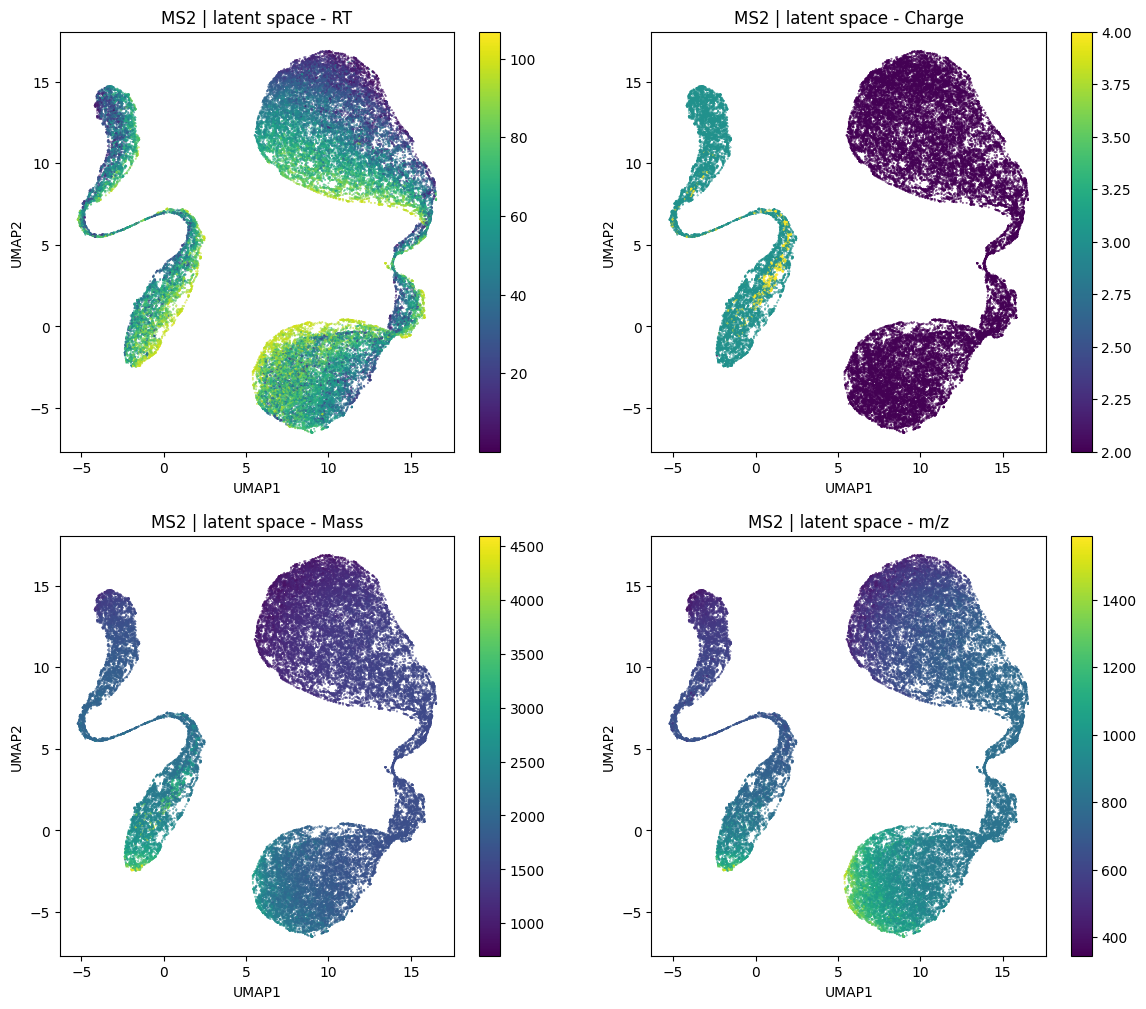

In [45]:
fig, axs = plt.subplots(figsize=(14, 12), ncols=2, nrows=2)

ax = axs[0][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Retention time'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - RT')
fig.colorbar(sp)

ax = axs[0][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Charge'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Charge')
fig.colorbar(sp)

ax = axs[1][0]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['Mass'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Mass')
fig.colorbar(sp)

ax = axs[1][1]
sp = ax.scatter(umap_embedding[:,0], umap_embedding[:,1], c=MS2_data_subset['m/z'], s=0.1)
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - m/z')
fig.colorbar(sp)

Let's plot the latent space for each specie. We'll scale based on proportion of peptides in each specie.

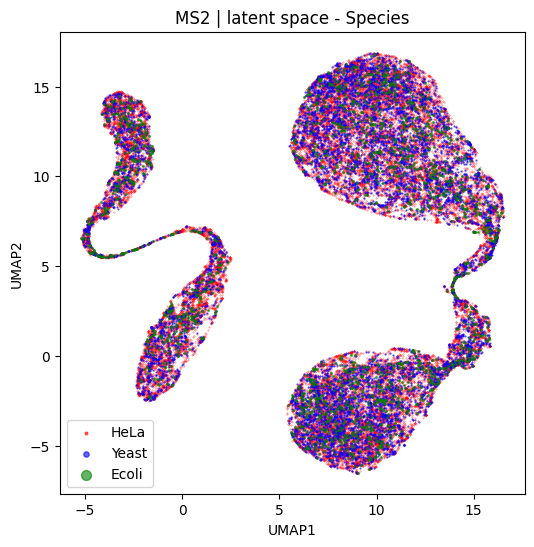

In [46]:
colors = ['red', 'blue', 'green']
color_map = {species: color for species, color in zip(MS2_data_subset['Species'].unique(), colors)}
species_size = {'HeLa': .1, 'Yeast': .4, 'Ecoli': 1.4}

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - Species')

for species, color in color_map.items():
    umap1 = umap_embedding[MS2_data_subset['Species'] == species][:,0]
    umap2 = umap_embedding[MS2_data_subset['Species'] == species][:,1]
    ax.scatter(umap1, umap2, c=color, s=species_size[species], label=species, alpha=0.6)

ax.legend(markerscale=6)

Let's also plot the latent space of the MS2 data together with some low coverage and high coverage peptides.

Text(0.5, 1.0, 'low coverage peptides')

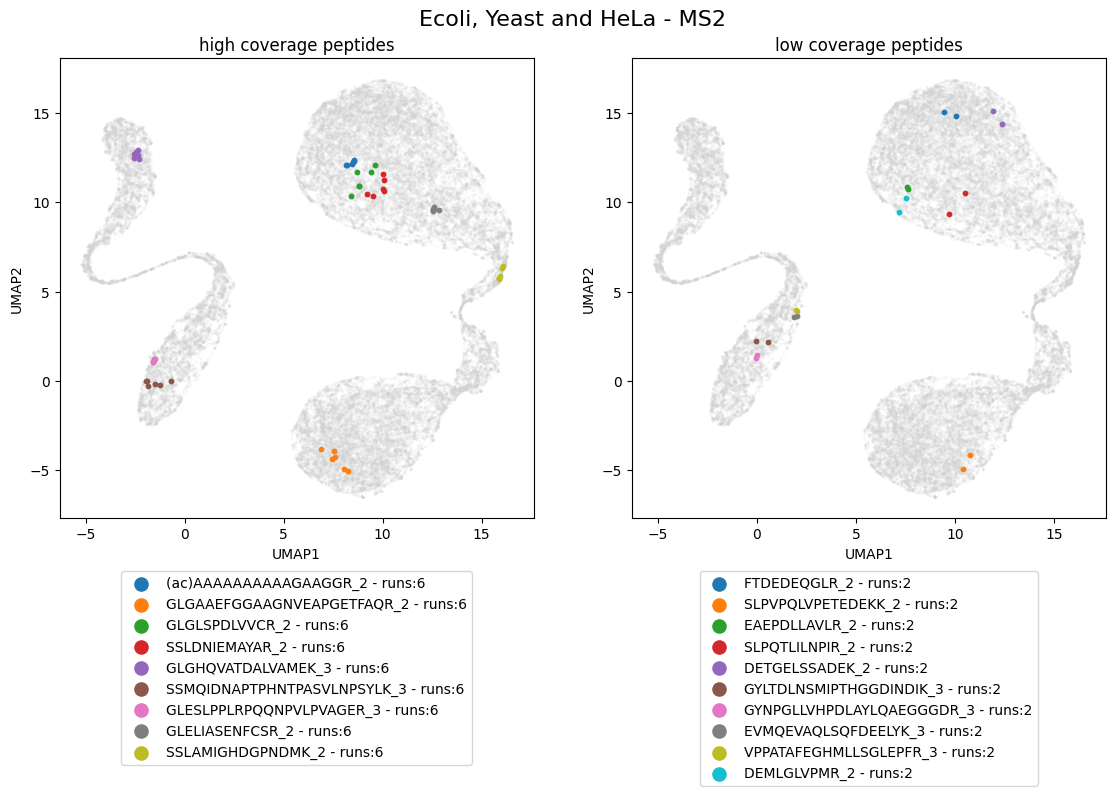

In [47]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
fig.tight_layout(pad=4.0)

fig.suptitle('Ecoli, Yeast and HeLa - MS2', fontsize=16)

# high coverage peptides
ax = axs[0]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(high_coverage_peptides_to_include):
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptides_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('high coverage peptides')

# low coverage peptides
ax = axs[1]
ax.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.01, color='lightgrey')

for i, peptide in enumerate(low_coverage_peptides_to_include):
    peptide_ref_indices = np.where(MS2_data_subset['PrecursorID'] == peptide)
    ax.scatter(umap_embedding[peptide_ref_indices,0], umap_embedding[peptide_ref_indices,1], s=10, color=plt.cm.tab10(i), label=f"{peptide[1:]} - runs:{peptides_abundances[peptide]}")

ax.legend(markerscale=3, loc='upper center', bbox_to_anchor=(0.5, -0.1))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('low coverage peptides')

Let's also plot the latent representation of both MS2 datasets.

In [48]:
all_MS2_data = pd.concat([HeLa_MS2_data, species_MS2_data], ignore_index=True)

In [49]:
latent = model.get_latent_representations(all_MS2_data[features])

In [50]:
print(f"Number of prototypes: {all_MS2_data['PrecursorID'].nunique()}")

Number of prototypes: 86678


In [51]:
N = 50_000
M = N // 2

random_indices_1 = np.random.choice(range(len(HeLa_MS2_data)), size=M, replace=False)
random_indices_2 = np.random.choice(range(len(species_MS2_data)), size=M, replace=False)

random_indices = np.concatenate((random_indices_1, random_indices_2 + len(HeLa_MS2_data)))

MS2_embeddings_subset = latent[random_indices]
MS2_data_subset = all_MS2_data.iloc[random_indices]

In [52]:
reducer = umap.UMAP(metric = 'cosine')
umap_embedding = reducer.fit_transform(MS2_embeddings_subset)

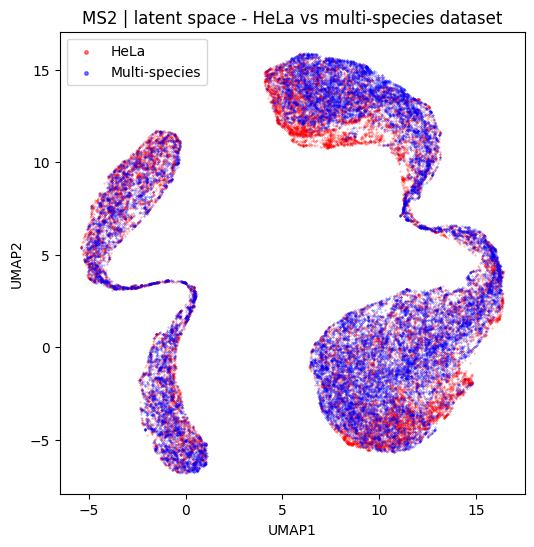

In [53]:
colors = ['red', 'blue']
color_map = {dataset: color for dataset, color in zip(MS2_data_subset['Dataset'].unique(), colors)}

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('MS2 | latent space - HeLa vs multi-species dataset')

for dataset, color in color_map.items():
    umap1 = umap_embedding[MS2_data_subset['Dataset'] == dataset][:,0]
    umap2 = umap_embedding[MS2_data_subset['Dataset'] == dataset][:,1]
    ax.scatter(umap1, umap2, c=color, s=.1, label=dataset, alpha=.5)

ax.legend(markerscale=8)

## False Transfer Rates for MS1 data

Let's compute the false transfer rate (FTR). Recall, all MS1 data is from HeLa cells. So we compute the FTR as the number of identifications in the MS1 data which are not HeLa divided by the total number of identifications in the MS1 data.

Let's extract the HeLa MS2 entries from the HeLa MS1 data.

In [54]:
HeLa_MS1_only_locs = HeLa_MS1_data.index.difference(HeLa_MS2_data.index)
HeLa_MS1_only_ilocs = HeLa_MS1_data.index.get_indexer(HeLa_MS1_only_locs)

In [55]:
HeLa_MS1_only = HeLa_MS1_data.iloc[HeLa_MS1_only_ilocs]

Let's append the species to the precursors.

In [56]:
species_precursor_id = all_MS2_data['Species'].astype(str).str.cat(all_MS2_data['PrecursorID'].astype(str), sep='')
all_MS2_data['PrecursorID'] = species_precursor_id

In [57]:
k = 15

identities, confidence = model.propagate(HeLa_MS1_only, all_MS2_data, k_neighbours=k)

Computing prototypes...
Propagating identities using 15 nearest neighbours...


Let's extract species from the precursor ID.

In [58]:
hela_filter = np.array([identity.startswith('HeLa') for identity in identities])
yeast_filter = np.array([identity.startswith('Yeast') for identity in identities])
ecoli_filter = np.array([identity.startswith('Ecoli') for identity in identities])

Let's plot the false transfer rate as a function of the confidence threshold.

/tmp/ipykernel_9912/1202105180.py:25: RuntimeWarning: invalid value encountered in scalar divide
  ftr = np.sum(identified_counts) / np.sum(confidence > threshold)


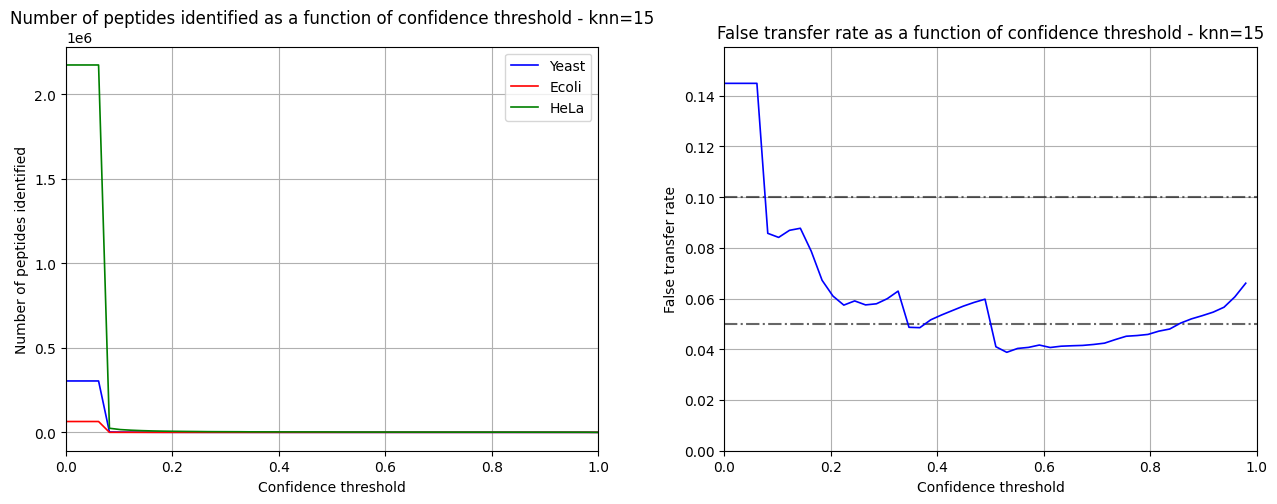

In [59]:
confidence_thresholds = np.linspace(0., 1, 50)

fig, axes = plt.subplots(figsize=(14, 6), ncols=2, nrows=1)
fig.tight_layout(pad=6.0)

# number of peptides identified per species
ax = axes[0]

for species_filter, color in zip([yeast_filter, ecoli_filter, hela_filter], ['blue', 'red', 'green']):
    identified_counts = [np.sum(confidence[species_filter] > threshold) for threshold in confidence_thresholds]
    ax.plot(confidence_thresholds, identified_counts, color=color, linewidth=1.2)

ax.set_xlabel('Confidence threshold')
ax.set_ylabel('Number of peptides identified')
ax.set_title(f'Number of peptides identified as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(['Yeast', 'Ecoli', 'HeLa'])

# false transfer rate
false_transfer_rates = []
for threshold in confidence_thresholds:
    identified_counts = [np.sum(confidence[species_filter] > threshold) for species_filter in [yeast_filter, ecoli_filter]]
    ftr = np.sum(identified_counts) / np.sum(confidence > threshold)
    false_transfer_rates.append(ftr)

ax = axes[1]
ax.axhline(y=0.05, color='black', linestyle='dashdot', alpha=0.6)
ax.axhline(y=0.1, color='black', linestyle='dashdot', alpha=0.6)

ax.plot(confidence_thresholds, false_transfer_rates, color='blue', linewidth=1.2)

ax.set_xlabel('Confidence threshold')
ax.set_ylabel('False transfer rate')
ax.set_title(f'False transfer rate as a function of confidence threshold - knn={k}')
ax.set_xlim([0, 1])
ax.set_ylim([0, np.nanmax(false_transfer_rates) * 1.1])
ax.grid(True)
ax.set_axisbelow(True)

Let's down-sample the proportion of HeLa prototypes in the MS2 dataset and see how the false transfer rate changes.

We'll start by computing the prototypes as we'll filter them based on different thresholds.

In [60]:
prototypes = model._compute_prototypes(all_MS2_data)

In [61]:
np_starts_with = lambda array, prefix: np.array([element.startswith(prefix) for element in array])

In [62]:
HeLa_prototype_indices = np.where(np_starts_with(prototypes['PrecursorID'], 'HeLa'))[0]

yeast_prototype_indices = np.where(np_starts_with(prototypes['PrecursorID'], 'Yeast'))[0]
ecoli_prototype_indices = np.where(np_starts_with(prototypes['PrecursorID'], 'Ecoli'))[0]

non_HeLa_prototype_indices = np.concatenate((yeast_prototype_indices, ecoli_prototype_indices))

In [63]:
non_HeLa_prototypes = {key: value[non_HeLa_prototype_indices] for key, value in prototypes.items()}

In [64]:
# define the proportion of HeLa prototypes to use and the confidence thresholds to test
N_prototypes = prototypes['PrecursorID'].shape[0]
max_HeLa_proportion = len(HeLa_prototype_indices) / N_prototypes
HeLa_proportions = [max_HeLa_proportion, .7, .5, .3]
confidence_thresholds = np.linspace(0., 1, 50)
k = 15

# compute the false transfer rate for each combination of HeLa proportion and confidence threshold
false_transfer_rates = []

for HeLa_proportion in HeLa_proportions:
    print(f"Computing identities for HeLa prototype proportion: {HeLa_proportion:.2f}")

    HeLa_count = min(int(HeLa_proportion * N_prototypes), len(HeLa_prototype_indices))
    HeLa_prototype_subset_indices = HeLa_prototype_indices[:HeLa_count]

    prototype_indices = np.concatenate((HeLa_prototype_subset_indices, non_HeLa_prototype_indices))
    prototypes_subset = {key: value[prototype_indices] for key, value in prototypes.items()}

    identities, confidence = model._propagate_using_prototypes(HeLa_MS1_only, prototypes_subset, k_neighbours=k)

    for confidence_threshold in confidence_thresholds:
        confident_identities = identities[confidence > confidence_threshold]

        if len(confident_identities) == 0:
            continue

        hela_identities = np_starts_with(confident_identities, 'HeLa')
        ftr = np.sum(~hela_identities) / len(confident_identities)
        false_transfer_rates.append((HeLa_proportion, confidence_threshold, ftr))

Computing identities for HeLa prototype proportion: 0.83
Computing identities for HeLa prototype proportion: 0.70
Computing identities for HeLa prototype proportion: 0.50
Computing identities for HeLa prototype proportion: 0.30


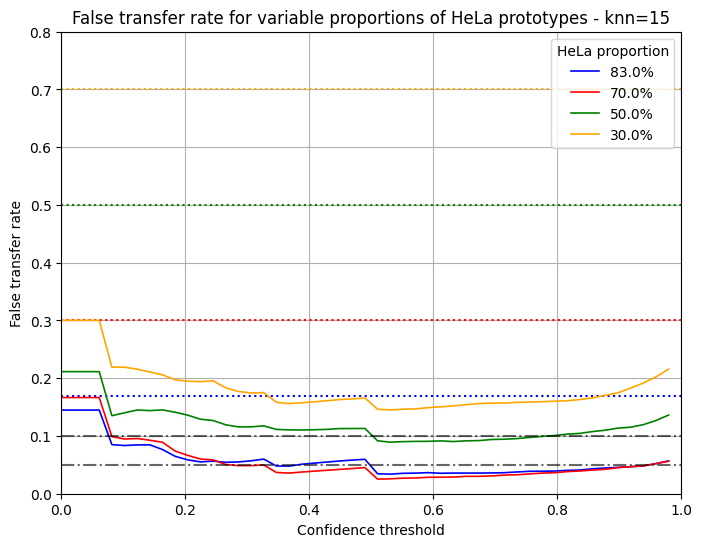

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['blue', 'red', 'green', 'orange']

for i, HeLa_proportion in enumerate(HeLa_proportions):
    ftrs = np.array([ftr for ftr in false_transfer_rates if ftr[0] == HeLa_proportion])
    ax.plot(ftrs[:,1], ftrs[:,2], linewidth=1.2, label=f"{HeLa_proportion*100:.1f}%", color=colors[i])
    ax.axhline(y=1-HeLa_proportion, color=colors[i], linestyle='dotted')

ax.set_xlabel('Confidence threshold')
ax.set_ylabel('False transfer rate')
ax.set_title(f'False transfer rate for variable proportions of HeLa prototypes - knn={k}')
ax.set_xlim([0, 1])
ax.set_ylim([0, .8])
ax.axhline(y=0.05, color='black', linestyle='dashdot', alpha=0.6)
ax.axhline(y=0.10, color='black', linestyle='dashdot', alpha=0.6)
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(title='HeLa proportion', loc='upper right')